In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 80, 80

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 32

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/drive/MyDrive/medieval/classificationTask/train"
VAL_DIR="/content/drive/MyDrive/medieval/classificationTask/validation"

# Use os.listdir to get a list of directories (subfolders) in the specified directory
CLASSES_LIST = [folder for folder in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, folder))]

# CLASSES_LIST now contains the names of subdirectories (folders) within DATASET_DIR
print(CLASSES_LIST)

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
#CLASSES_LIST = ["Defensive Backhand Backspin", "Defensive Backhand Block", "Defensive Backhand Push", "Defensive Forehand Backspin"]

['Serve Backhand Loop', 'Serve Forehand Topspin', 'Serve Forehand Loop', 'Serve Forehand Sidespin', 'Serve Backhand Backspin', 'Offensive Forehand Loop', 'Serve Backhand Sidespin', 'Serve Backhand Topspin', 'Serve Forehand Backspin', 'Defensive Forehand Push', 'Defensive Forehand Block', 'Defensive Forehand Backspin', 'Offensive Backhand Flip', 'Offensive Backhand Hit', 'Negative', 'Defensive Backhand Push', 'Offensive Forehand Hit', 'Offensive Backhand Loop', 'Offensive Forehand Flip', 'Defensive Backhand Block', 'Defensive Backhand Backspin']


In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
def create_dataset(dir):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(dir, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(dir, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset(DATASET_DIR)

Extracting Data of Class: Serve Backhand Loop
Extracting Data of Class: Serve Forehand Topspin
Extracting Data of Class: Serve Forehand Loop
Extracting Data of Class: Serve Forehand Sidespin
Extracting Data of Class: Serve Backhand Backspin
Extracting Data of Class: Offensive Forehand Loop
Extracting Data of Class: Serve Backhand Sidespin
Extracting Data of Class: Serve Backhand Topspin
Extracting Data of Class: Serve Forehand Backspin
Extracting Data of Class: Defensive Forehand Push
Extracting Data of Class: Defensive Forehand Block
Extracting Data of Class: Defensive Forehand Backspin
Extracting Data of Class: Offensive Backhand Flip
Extracting Data of Class: Offensive Backhand Hit
Extracting Data of Class: Negative
Extracting Data of Class: Defensive Backhand Push
Extracting Data of Class: Offensive Forehand Hit
Extracting Data of Class: Offensive Backhand Loop
Extracting Data of Class: Offensive Forehand Flip
Extracting Data of Class: Defensive Backhand Block
Extracting Data of Cl

In [ ]:
import pickle

def save_list(my_list, filename):
    with open(filename, 'wb') as fp:
        pickle.dump(my_list, fp)

def load_list(filename):
    with open(filename, 'rb') as fp:
        my_list = pickle.load(fp)
    return my_list

In [ ]:
import numpy as np
def save_dataset(features, labels, video_files_paths, save_dir):
    # Save the features, labels, and video file paths to separate files.
    np.save(os.path.join(save_dir, 'features.npy'), features)
    np.save(os.path.join(save_dir, 'labels.npy'), labels)
    save_list(video_files_paths,os.path.join(save_dir,'video_files_paths.bin'))

# Usage:
# Call this function to save your dataset objects.
save_dataset(features, labels, video_files_paths, '/content/drive/MyDrive/med/train')


In [ ]:
# Create the dataset.
Vfeatures, Vlabels, Vvideo_files_paths = create_dataset(VAL_DIR)

Extracting Data of Class: Serve Backhand Loop
Extracting Data of Class: Serve Forehand Topspin
Extracting Data of Class: Serve Forehand Loop
Extracting Data of Class: Serve Forehand Sidespin
Extracting Data of Class: Serve Backhand Backspin
Extracting Data of Class: Offensive Forehand Loop
Extracting Data of Class: Serve Backhand Sidespin
Extracting Data of Class: Serve Backhand Topspin
Extracting Data of Class: Serve Forehand Backspin
Extracting Data of Class: Defensive Forehand Push
Extracting Data of Class: Defensive Forehand Block
Extracting Data of Class: Defensive Forehand Backspin
Extracting Data of Class: Offensive Backhand Flip
Extracting Data of Class: Offensive Backhand Hit
Extracting Data of Class: Negative
Extracting Data of Class: Defensive Backhand Push
Extracting Data of Class: Offensive Forehand Hit
Extracting Data of Class: Offensive Backhand Loop
Extracting Data of Class: Offensive Forehand Flip
Extracting Data of Class: Defensive Backhand Block
Extracting Data of Cl

In [ ]:
save_dataset(Vfeatures, Vlabels, Vvideo_files_paths,'/content/drive/MyDrive/med/validation' )

In [ ]:
def load_dataset(load_dir):
    # Load the features, labels, and video file paths from the saved files.
    features = np.load(os.path.join(load_dir, 'features.npy'))
    labels = np.load(os.path.join(load_dir, 'labels.npy'))
    video_files_paths = load_list(os.path.join(load_dir, 'video_files_paths.bin'))
    return features, labels, video_files_paths

# Usage:
# Call this function to load your dataset objects when needed.
features, labels, video_files_paths = load_dataset('/content/drive/MyDrive/med/train')
vfeatures,vlabels,vvideo_files_paths= load_dataset('/content/drive/MyDrive/med/validation')


In [ ]:
print(labels[805])

20


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
print(len(one_hot_encoded_labels))

806


In [ ]:
one_hot_encoded_vlabels=to_categorical(vlabels)

In [ ]:
newfeatures_train, newfeatures_test, newlabels_train, newlabels_test=features,vfeatures,one_hot_encoded_labels,one_hot_encoded_vlabels

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
# Construct the required convlstm model.
convlstm_model = create_convlstm_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 32, 78, 78, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 32, 39, 39, 4)    0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 32, 39, 39, 4)    0         
 ibuted)                                                         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 32, 37, 37, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 32, 19, 19, 8)    0         
 3D)                                                             
                                                        

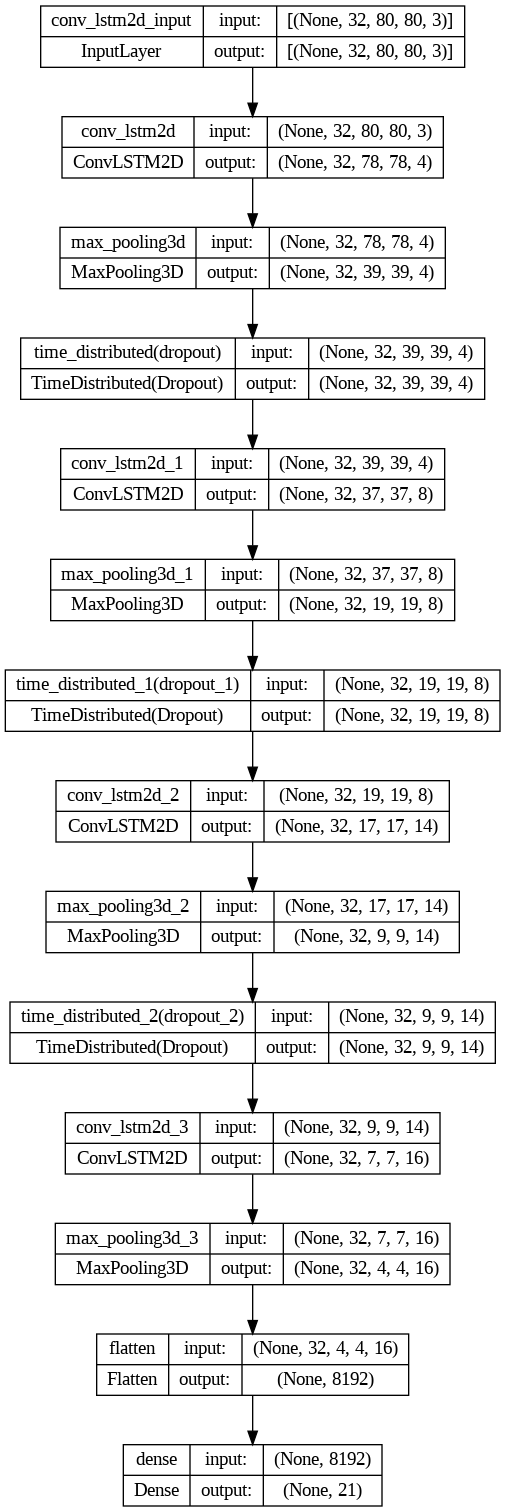

In [ ]:
# Plot the structure of the contructed model.
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of Early Stopping Callback
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x = newfeatures_train, y = newlabels_train, epochs = 50, batch_size = 4,
                                                     shuffle = True, validation_data = (newfeatures_test,newlabels_test ),
                                                     callbacks = [early_stopping_callback])


Epoch 1/50
202/202 [==============================] - 1448s 7s/step - loss: 2.8498 - accuracy: 0.1266 - val_loss: 2.5092 - val_accuracy: 0.1696
Epoch 2/50
202/202 [==============================] - 1423s 7s/step - loss: 2.2896 - accuracy: 0.2419 - val_loss: 2.1218 - val_accuracy: 0.2826
Epoch 3/50
202/202 [==============================] - 1419s 7s/step - loss: 1.9134 - accuracy: 0.3722 - val_loss: 1.7131 - val_accuracy: 0.4217
Epoch 4/50
202/202 [==============================] - 1435s 7s/step - loss: 1.4974 - accuracy: 0.5099 - val_loss: 1.3745 - val_accuracy: 0.5348
Epoch 5/50
202/202 [==============================] - 1424s 7s/step - loss: 1.1417 - accuracy: 0.6104 - val_loss: 1.3466 - val_accuracy: 0.5652
Epoch 6/50
202/202 [==============================] - 1424s 7s/step - loss: 0.9253 - accuracy: 0.6960 - val_loss: 1.2062 - val_accuracy: 0.6261
Epoch 7/50
202/202 [==============================] - 1437s 7s/step - loss: 0.7518 - accuracy: 0.7481 - val_loss: 0.9281 - val_accuracy:

In [ ]:
# Evaluate the trained model.
model_evaluation_history = convlstm_model.evaluate(newfeatures_test, newlabels_test)

8/8 [==============================] - 99s 13s/step - loss: 0.8912 - accuracy: 0.7304


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
convlstm_model.save("/content/drive/MyDrive/med/models/"+"80-32"+model_file_name)

In [ ]:
from tensorflow.keras.models import load_model
# Specify the path to the saved model file.
model_file_path = "/content/drive/MyDrive/med/models/80-32convlstm_model___Date_Time_2023_11_11__17_35_55___Loss_0.8911927342414856___Accuracy_0.730434775352478.h5"

convlstm_model = load_model(model_file_path)

In [ ]:
r=convlstm_model.predict(newfeatures_test)
results=[np.argmax(i) for i in r]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
l=[np.argmax(i) for i in newlabels_test]
# test_predictions_word and test_tags_word are one-hot encoded labels
print(f1_score(results, l, average='weighted', pos_label=None))

# test_predictions_word and test_tags_word are one-hot encoded labels
#cm = confusion_matrix(r, l)
#print(cm)


8/8 [==============================] - 96s 11s/step
0.7294288165155886


In [ ]:
import xml.etree.ElementTree as ET
tree = ET.parse('/content/drive/MyDrive/medieval/classificationTask/test.xml')
root = tree.getroot()

videos = []
for video in root.findall('video'):
    name = video.get('name')
    class_ = video.get('class')
    videos.append({'name': name, 'class': class_})
print(videos)

[{'name': '283321395.mp4', 'class': 'UNKNOWN'}, {'name': '6443449410.mp4', 'class': 'UNKNOWN'}, {'name': '465222132.mp4', 'class': 'UNKNOWN'}, {'name': '42107641011.mp4', 'class': 'UNKNOWN'}, {'name': '825279532.mp4', 'class': 'UNKNOWN'}, {'name': '763278719.mp4', 'class': 'UNKNOWN'}, {'name': '1557879103.mp4', 'class': 'UNKNOWN'}, {'name': '9227108229.mp4', 'class': 'UNKNOWN'}, {'name': '5252110772.mp4', 'class': 'UNKNOWN'}, {'name': '81731056510.mp4', 'class': 'UNKNOWN'}, {'name': '5114210114.mp4', 'class': 'UNKNOWN'}, {'name': '675623119.mp4', 'class': 'UNKNOWN'}, {'name': '3551251014.mp4', 'class': 'UNKNOWN'}, {'name': '188884451.mp4', 'class': 'UNKNOWN'}, {'name': '1045869846.mp4', 'class': 'UNKNOWN'}, {'name': '548689525.mp4', 'class': 'UNKNOWN'}, {'name': '5810475928.mp4', 'class': 'UNKNOWN'}, {'name': '8685551045.mp4', 'class': 'UNKNOWN'}, {'name': '693627377.mp4', 'class': 'UNKNOWN'}, {'name': '61012688410.mp4', 'class': 'UNKNOWN'}, {'name': '423191134.mp4', 'class': 'UNKNOWN'

In [ ]:
def create_testset(dir):
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    #labels = []
    video_file_names = []
    print(f'Extracting Data ')
    files_list = os.listdir(os.path.join(dir))
    # Iterate through all the files present in the files list.
    for file_name in files_list:
        # Get the complete video path.
        video_file_path = os.path.join(dir,file_name)
        # Extract the frames of the video file.
        frames = frames_extraction(video_file_path)
        # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
        # So ignore the vides having frames less than the SEQUENCE_LENGTH.
        if len(frames) == SEQUENCE_LENGTH:
            # Append the data to their repective lists.
            features.append(frames)
            video_file_names.append(file_name)

    # Converting the list to numpy arrays
    features = np.asarray(features)

    # Return the frames, class index, and video file path.
    return features,video_file_names

In [ ]:
features,names=create_testset('/content/drive/MyDrive/medieval/classificationTask/test')

Extracting Data 


In [ ]:
import numpy as np
def save_testset(features,video_file_names, save_dir):
    # Save the features, labels, and video file paths to separate files.
    np.save(os.path.join(save_dir, 'features.npy'), features)
    save_list(video_file_names,os.path.join(save_dir,'names.bin'))

# Usage:
# Call this function to save your dataset objects.
save_testset(features, names,'/content/drive/MyDrive/med/test')


In [ ]:
def load_testset(load_dir):
    # Load the features, labels, and video file paths from the saved files.
    features = np.load(os.path.join(load_dir, 'features.npy'))
    video_file_names = load_list(os.path.join(load_dir, 'names.bin'))
    return features, video_file_names

# Usage:
# Call this function to load your dataset objects when needed.
features,names = load_testset('/content/drive/MyDrive/med/test')

In [ ]:
d={}
e=convlstm_model.predict(features)

4/4 [==============================] - 52s 12s/step


In [ ]:
for i,j in zip(names,e):
  print(i," -- ",CLASSES_LIST[np.argmax(j)])
  d[i]=CLASSES_LIST[np.argmax(j)]

7681081995.mp4  --  Negative
972569432.mp4  --  Serve Forehand Topspin
537163678.mp4  --  Offensive Forehand Flip
64824110108.mp4  --  Serve Forehand Sidespin
9923410763.mp4  --  Serve Forehand Loop
9227108229.mp4  --  Serve Backhand Topspin
8141038313.mp4  --  Serve Forehand Backspin
84151011096.mp4  --  Defensive Backhand Backspin
751658299.mp4  --  Defensive Forehand Block
5294510675.mp4  --  Defensive Backhand Block
465222132.mp4  --  Serve Forehand Topspin
4231021236.mp4  --  Defensive Forehand Block
4102155774.mp4  --  Serve Backhand Backspin
5252110772.mp4  --  Defensive Backhand Backspin
836848776.mp4  --  Serve Backhand Loop
3765109497.mp4  --  Serve Forehand Loop
423191134.mp4  --  Serve Backhand Topspin
4104376921.mp4  --  Defensive Forehand Backspin
716636929.mp4  --  Serve Forehand Backspin
573125959.mp4  --  Offensive Forehand Hit
684127899.mp4  --  Serve Backhand Sidespin
75711015103.mp4  --  Serve Backhand Loop
6355106689.mp4  --  Serve Backhand Topspin
887152322.mp4  -

In [ ]:
root = ET.Element('videos')
for video in videos:
    child = ET.SubElement(root, 'video')
    child.set('name', video['name'])
    child.set('class', d[video['name']])
tree = ET.ElementTree(root)
tree.write('/content/drive/MyDrive/med/test/new_file.xml')


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

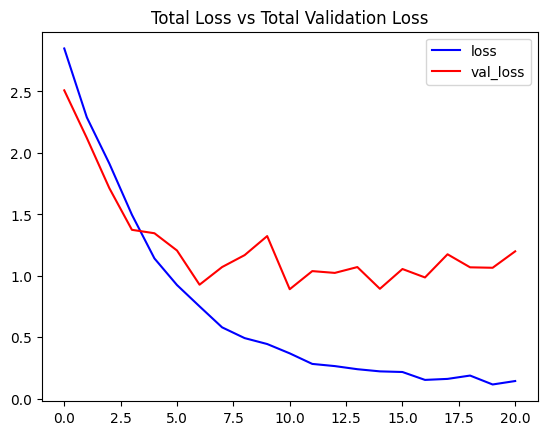

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

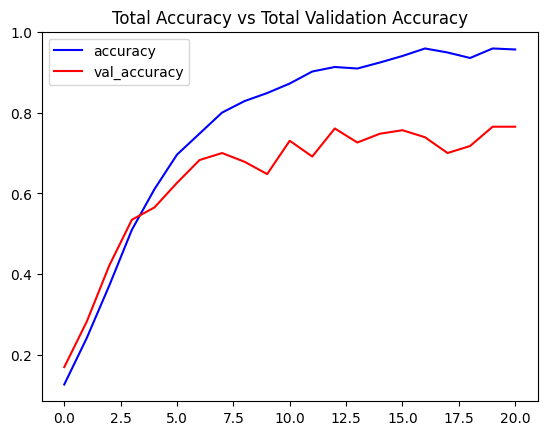

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')